# Sound

> This is the functionality used to collect audio observations from game play.

In [ ]:
#| default_exp sound
#| export
from algorithmic_gamer.types import *

import pyaudio
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

### record audio 

utilizes [pyaudio](https://pypi.org/project/PyAudio/) to record the `windows stereo mixer`, you must be enable it in windows sound settings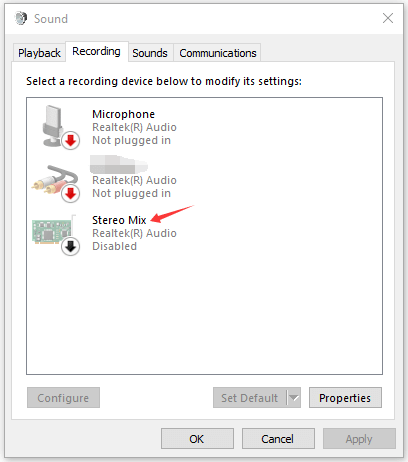

In [ ]:
#| export
def get_input_device_index(p, device_name='Stereo Mix (Realtek(R) Audio)'):
    for i in range(p.get_device_count()):
        dev = p.get_device_info_by_index(i)
        if (dev['name'] == device_name and dev['hostApi'] == 0):
            dev_index = dev['index']
            return dev_index
        else:
            assert f'{device_name} was not found'

`get_input_device_index` resolves the the device index of the `device_name`. `p` is the reference to `pyaudio.PyAudio()` object.

In [ ]:
#| export       
def detect_first_over_threshold(tensor, threshold):
    for i, element in enumerate(tensor):
        if abs(element) > threshold:
            return i
    return -1

def normalize_audio(audio):
    audio = audio.astype(np.float32)
    audio /= 32768
    return audio  

def record_audio(duration, device_name='Stereo Mix (Realtek(R) Audio)', normalize=True, verbose=False):
    """
    duration: length of to time in seconds youd like to record.
    device_name: the name of the audio input device you'd like to use. If not specified, the default value is 'Stereo Mix (Realtek(R) Audio)'.
    normalize: shifts the signal to be in the range of [-1,1]
    verbose: prints intermediate information
    """
    
    # Initialize PyAudio
    p = pyaudio.PyAudio()
    
    #resolve device idx
    device_idx = get_input_device_index(p, device_name)
    
    # Open a stream
    stream = p.open(format=pyaudio.paInt16, channels=1, rate=44100, input=True, frames_per_buffer=1024, input_device_index = device_idx,)
    
    start_time = datetime.utcnow()
    if verbose:
        print(f'record audio start:{start_time}')
    # Read audio
    audio = np.empty((44100 * duration,), dtype=np.int16)
    for i in range(0, int(44100 / 1024 * duration)):
        audio[i * 1024: (i + 1) * 1024] = np.frombuffer(stream.read(1024), dtype=np.int16)
    end_time = datetime.utcnow()
    # Close the stream and terminate PyAudio
    stream.stop_stream()
    stream.close()
    p.terminate()
    
    #a hack that removes the first section of [-1,0,1] values 
    start_idx = detect_first_over_threshold(audio, 2)
    #a hack to prevent a bug that creates a loud spike of noise at the end of the sequence.
    end_idx = detect_first_over_threshold(audio, 12000)
    audio = audio[start_idx:end_idx]
    
    if normalize:
        audio = normalize_audio(audio)
    
    audio_sequence = SoundSequenceObservation(start_timestamp = start_time, end_timestamp = end_time, data = audio)
    
    return audio_sequence

async def a_record_audio(duration, device_name='Stereo Mix (Realtek(R) Audio)', normalize=True):
    return record_audio(duration, device_name, normalize)

`record_audio` takes a `duration` in seconds and `device_name` then records the audio from the `device_name` for `duration`.

In [ ]:
#|eval: false
audio_sequence = record_audio(duration=3, normalize=True)

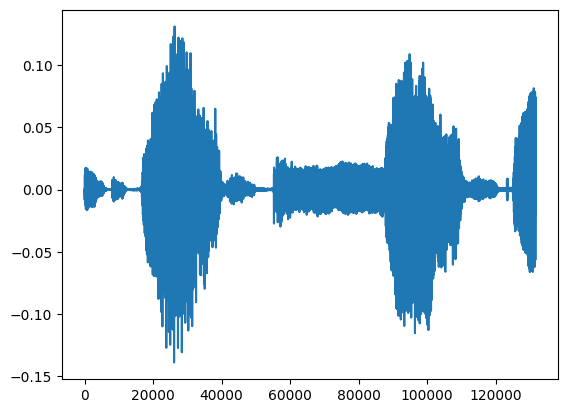

In [ ]:
#|eval: false
from IPython.display import Audio
# Plot the waveform of the recorded audio
plt.plot(audio_sequence.data)
plt.show()
Audio(data=audio_sequence.data, rate=44100)